In [1]:
import sys

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import cm
import matplotlib.patheffects as path_effects
from matplotlib import transforms

plt.style.use("small.style")

from matplotlib import patches

import numpy as np
from scipy import interpolate

import astropy
from astropy.table import Table
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM

import pandas
import bz2file

In [2]:
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)
print cosmo


def comoving_distance(z):
    return cosmo.comoving_distance(z).value

def age(z):
    return cosmo.age(z).value

def lookback_time(z):
    return cosmo.lookback_time(z).value

def redshift(z):
    return z

radial_scale = comoving_distance

cut=4000
cutx=9300
cuty=cut


FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


In [3]:
def text(ax,x,y,label,**p):
    """ """
    t = ax.text(x,y,label,**p)
    t.set_path_effects([path_effects.Stroke(linewidth=3, foreground='w'),path_effects.Normal()])
    return t

def radial(ax, r0, r1, angle, label=None, labelpos=1, plot=True, clip_path=None, **plotparams):
    sintheta = np.sin(angle*np.pi/180)
    costheta = np.cos(angle*np.pi/180)
    y0 = r0*sintheta
    y1 = r1*sintheta
    x0 = r0*costheta
    x1 = r1*costheta
    if plot:
        line, = ax.plot([x0,x1],[y0,y1],**plotparams)
        line.set_clip_path(clip_path)
    if label:
        yl = (y1-y0)*labelpos + y0
        xl = (x1-x0)*labelpos + x0
        xl -= sintheta * 30
        yl += costheta * 30
        text(ax, xl,yl,label,rotation=angle,horizontalalignment='center',verticalalignment='center',color='navy',zorder=21)

    return np.array([(x0,y0),(x1,y1)])
    
def arc(ax, r, angle, orientation=0, step=0.5, cut=False, plot=True, clip_path=None, **plotparams):
    """ """
    n = int(angle / step) + 1
    theta = (np.linspace(-1,1,n) * angle / 2. + orientation) * np.pi/180.
    x = np.cos(theta) * r
    y = np.sin(theta) * r
    
    if cut>0:
        ii = (y<cut)&(y>0)
        x = x[ii]
        y = y[ii]
    if plot:
        line, = ax.plot(x, y, **plotparams)
        line.set_clip_path(clip_path)
    return np.transpose([x, y])
    
    
def wedge(ax, angle=20, orientation=0, zmin=0.5, zmax=2, rmin=None, rmax=None, close=True, label=None, labelpos=1, edges=True, fill=False, facecolor='w', zorder=0, **plotparams):
    """ """
    if rmin:
        r0 = rmin
        r1 = rmax
    else:
        r0 = radial_scale(zmin)
        r1 = radial_scale(zmax)
        
    r = patches.Rectangle([0,0],cutx,cuty,facecolor='None',edgecolor='None')
    ax.add_patch(r)

    
    seg1 = radial(ax, r0, r1, orientation + angle/2.,label=label, labelpos=labelpos, plot=edges, zorder=zorder, clip_path=r, **plotparams)
    seg2 = radial(ax, r0, r1, orientation - angle/2.,plot=edges, zorder=zorder, clip_path=r, **plotparams)
    arc1 = arc(ax, r0, angle, orientation,plot=edges, zorder=zorder, clip_path=r,  **plotparams)
    arc2 = arc(ax, r1, angle, orientation, plot=close&edges, zorder=zorder, clip_path=r, **plotparams)
        
    if fill:
        poly = np.vstack([seg1,arc2[::-1],seg2[::-1],arc1])
        p = patches.Polygon(poly, facecolor=facecolor, edgecolor='k',zorder=zorder)
        ax.add_patch(p)
        p.set_clip_path(r)

        
def gradient_wedge(ax, angle=20, orientation=0, zmin=0.5, zmax=2, close=True, label=None, steps=100, cmap="Blues_r", **plotparams):
    """ """
    
    r0 = radial_scale(zmin)
    r1 = radial_scale(zmax)
    
    sm = cm.ScalarMappable(norm=colors.Normalize(r0,r1), cmap=plt.get_cmap(cmap))
    
    rr = np.linspace(r0,r1,steps)
    for i in range(len(rr)-1):
        r = (rr[i]+rr[i+1])/2.
        c = sm.to_rgba(r)
        wedge(ax, angle, orientation, rmin=rr[i], rmax=rr[i+1], edges=False, fill=True, facecolor=c)

    
# def trunc(x, prec):
#     return int(x/10**prec)*10**prec
    
def scale(ax, z0, z1, func, nsteps=10, y=-300, step=1, minorstep=0.5, title="", label_range=None, **plotparams):
    """ """
    r0 = radial_scale(z0)
    r1 = radial_scale(z1)

    plt.plot([r0,r1],[y,y],**plotparams)
    
    ax.text(0,y-50,title,verticalalignment='top')

    
    zz = np.linspace(0, 11, 1000)
    scale_at_z = radial_scale(zz)
    interper = interpolate.interp1d(func(zz), scale_at_z)
    
    a = func(z0)
    b = func(z1)

    if b < a:
        a,b = b,a
    tick_labels = np.arange(0, b+step, step)
    ii = (tick_labels>a)&(tick_labels<b)
    tick_labels = tick_labels[ii]
    
    tick_pos = interper(tick_labels)
    
    for i in range(len(tick_labels)):
        r = tick_pos[i]
        ax.plot([r, r], [y-50, y], c='k')
        if (tick_labels[i]>=label_range[0])&(tick_labels[i]<=label_range[1]):
            ax.text(r, y-50, "%g"%tick_labels[i], rotation=0, verticalalignment='top', horizontalalignment='center')
        
    tick_labels = np.arange(0, b+minorstep, minorstep)
    ii = (tick_labels>a)&(tick_labels<b)
    tick_labels = tick_labels[ii]
    
    tick_pos = interper(tick_labels)
    
    for i in range(len(tick_labels)):
        r = tick_pos[i]
        ax.plot([r, r], [y-25, y], c='k')



In [19]:
def plot_sdss(ax, path="data/main_granett.csv",orientation=45,**plotparams):
    """ """
    cat = np.loadtxt(path,delimiter=",",skiprows=1,unpack=True)
    z,ra,dec = cat[2:5]
    r = radial_scale(z)
    theta = (ra+orientation)*np.pi/180
    x = np.cos(theta)*r
    y = np.sin(theta)*r
    
    ii = (x>0)&(y>0)
    ax.scatter(x[ii],y[ii],**plotparams)
    
    

    print >>sys.stderr, "Plotted SDSS",path
    
def plot_vipers(ax, path="data/w1_spec_radec.txt",zmin=0.4,zmax=1.2, orientation=45,label="VIPERS", zorder=10, **plotparams):
    """ """
    cat = np.loadtxt(path,unpack=True)
    ra,dec,z = cat
    ii = (z > zmin)&(z < zmax)
    ra = ra[ii]
    dec = dec[ii]
    z = z[ii]
    r = radial_scale(z)
    theta = (ra+orientation)*np.pi/180
    x = np.cos(theta)*r
    y = np.sin(theta)*r
    
    wedge(ax, ra.max()-ra.min(), (ra.max()+ra.min())/2+orientation, label=label, labelpos=0.8, zmin=0.4, zmax=1.2, c='k', fill=True, zorder=zorder-1)
    
    ax.scatter(x,y,zorder=zorder,**plotparams)
    
    print "vipers direction", ra.max()-ra.min()+1, (ra.max()+ra.min())/2+orientation
    
    print >>sys.stderr, "Plotted VIPERS",path

def plot_pfs(ax, path="data/3837.fits", zmin=0.7, zmax=1.2, orientation=45, label="PFS Deep", **plotparams):
    """ """
    with fits.open(path, memmap=False) as hdul:
        data = hdul[-1].data
        ra = data['ra_gal']
        dec = data['dec_gal']
        z = data['observed_redshift_gal']
        sel = (ra < 4)
        ra = ra[sel]
        dec = dec[sel]
        z = z[sel]
        
#         o = np.random.uniform(0,1,len(z)).argsort()[:10000]
#         ra = ra[o]
#         dec = dec[o]
#         z = z[o]        
        ra -= 2
        
        r = radial_scale(z)*1.5
        rmin = radial_scale(zmin)
        rmax = radial_scale(zmax)
        ii = (r>rmin)&(r<rmax)
        r = r[ii]
        ra = ra[ii]
        
        theta = (ra+orientation)*np.pi/180
        x = np.cos(theta)*r
        y = np.sin(theta)*r
        
        sig = (r.max()-r.min())/2.
        sf = np.exp(-(r - r.min())**2/2./sig**2)
        sf /= sf.max()*5
        sel = np.random.uniform(0,1,len(r))<sf
        
        ax.scatter(x[sel],y[sel],**plotparams)

        print >>sys.stderr, "Plotted PFS",path
        
def plot_pfswide(ax, path="data/3838.csv.bz2", zmin=0.7, zmax=2.5, orientation=45, label="PFS Wide", **plotparams):
    """ """
    with bz2file.BZ2File(path) as galaxy_fd:
        data = pandas.read_csv(galaxy_fd, sep=',', index_col=False, comment='#', na_values = '\N')

        ra = data['ra_gal']
        dec = data['dec_gal']
        z = data['observed_redshift_gal']
        sel = (dec<0.5)&(ra<60)
        ra = ra[sel]
        dec = dec[sel]
        z = z[sel]
                
        r = radial_scale(z) * 1.05
        ii = r > radial_scale(zmin)
        r = r[ii]
        z = z[ii]
        ra = ra[ii]
        
        theta = (ra+orientation)*np.pi/180
        x = np.cos(theta)*r
        y = np.sin(theta)*r
        
        sig = (r.max()-r.min())/2.
        sf = np.exp(-(r - r.min())**2/2./sig**2)
        sf /= sf.max()*5
        sel = np.random.uniform(0,1,len(r))<sf
        
        sel = sel & (y<cut)
        
        ax.scatter(x[sel],y[sel],**plotparams)

        print >>sys.stderr, "Plotted PFS",path        

def plot_dawn(ax, path="data/3837.fits", zmin=1.5, zmax=9, orientation=45, label="Origins", **plotparams):
    """ """
    with fits.open(path, memmap=False) as hdul:
        data = hdul[-1].data
        ra = data['ra_gal']
        dec = data['dec_gal']
        z = data['observed_redshift_gal']
        
                
        ra -= (ra.min()+ra.max())/2.
        
        r = radial_scale(z)
        theta = ra*np.pi/180
        x = np.cos(theta)*r +  radial_scale(0.9)
        y = np.sin(theta)*r
        
        theta = np.arctan2(y, x)
        r = np.sqrt(x**2+y**2)*1.1
        
        ii = np.abs(theta) < 2.5*np.pi/180

        print r.min(), radial_scale(zmin)
        
        ii = np.logical_and(ii, r > radial_scale(zmin))
        
        theta = theta[ii]
        r = r[ii]
        theta += orientation*np.pi/180
        
        x = np.cos(theta)*r
        y = np.sin(theta)*r
        
        sig = (r.max()-r.min())/2.
        sf = np.exp(-(r - r.min())**2/2./sig**2)
        sf /= sf.max()*2
        sel = np.random.uniform(0,1,len(r))<(sf/5)

        x = x[sel]
        y = y[sel]
        r = r[sel]
        s = (r*1./np.mean(r))**5
        s[s<1] = 1
        print s.min(),s.max()
        ax.scatter(x,y,s=s,**plotparams)

        print >>sys.stderr, "Plotted dawn",path


Plotted PFS data/3837.fits
Plotted PFS data/3838.csv.bz2


3429.8429628072236 4363.85576623
1.0 7.662192258834606


Plotted dawn data/3837.fits


3429.8429628072236 4363.85576623
1.0 7.57969258546216


Plotted dawn data/3837.fits
Plotted SDSS data/main_granett.csv
Plotted SDSS data/LRGagain_granett.csv


vipers direction 9.559586 27.969054


Plotted VIPERS data/w1_spec_radec.txt


vipers direction 6.343821999999989 399.21710299999995


Plotted VIPERS data/w4_spec_radec.txt


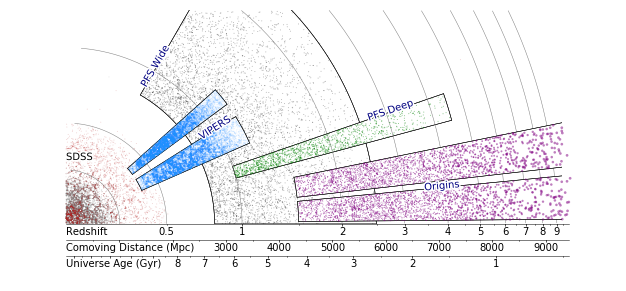

In [21]:
plt.figure(figsize=(8,4))
ax = plt.subplot(111, aspect='equal')

wedge(ax, 60, zmin=0.8, zmax=2.5, orientation=30, c='k',  fill=True, label="PFS Wide",labelpos=0.2, zorder=0)
wedge(ax, 4, zmin=1, zmax=4.5, orientation=17, c='k',  fill=True, label="PFS Deep",labelpos=0.75, zorder=2)
wedge(ax, 5, zmin=1.5, zmax=12, orientation=9, close=False, c='k', fill=True, label=None,zorder=3)
wedge(ax, 5, zmin=1.5, zmax=12, orientation=3, close=False, c='k', fill=True, label="Origins",labelpos=0.5, zorder=3)


scale(ax, 0, 10, redshift, step=1, minorstep=0.5, label_range=(1,10), title="Redshift", y=0, c='k')
scale(ax, 0, 10, comoving_distance, step=1000, minorstep=500,  label_range=(3000,9000), title="Comoving Distance (Mpc)", y=-300, c='k')
scale(ax, 0, 10, age,title="Universe Age (Gyr)", step = 1, minorstep=0.5, label_range=(0,8), y=-600, c='k')
# scale(ax, 0, 10, lookback_time,title="Lookback time Age (Gyr)", step = 0.5, y=-1300, c='g')

ax.text(radial_scale(0.5), -50, "%g"%0.5, rotation=0, verticalalignment='top', horizontalalignment='center')


plot_pfs(ax, zmin=1, zmax=4.5, orientation=17, alpha=0.5,s=1,edgecolor='None', c='g', label="PFS", zorder=10)
plot_pfswide(ax, zmin=0.8, zmax=2.5, orientation=0, alpha=0.3,s=1,edgecolor='None', c='k', label="PFS Wide",zorder=1.1)

plot_dawn(ax, zmin=1.5, zmax=9, orientation=3, alpha=0.5,edgecolor='None', c='purple', label="Origins", zorder=10)
plot_dawn(ax, zmin=1.5, zmax=9, orientation=9, alpha=0.5,edgecolor='None', c='purple', label="Origins", zorder=10)

plot_sdss(ax, c='grey',alpha=0.2,s=1,edgecolor='None')
plot_sdss(ax, path="data/LRGagain_granett.csv", c='firebrick',alpha=0.2,s=1,edgecolor='None')
plot_vipers(ax, path="data/w1_spec_radec.txt", orientation=-6.5, c='dodgerblue',alpha=0.1,s=1,edgecolor='None',zorder=10)
plot_vipers(ax, path="data/w4_spec_radec.txt", orientation=66.5, label=None, c='dodgerblue',alpha=0.1,s=1,edgecolor='None',zorder=10)

arc(ax, radial_scale(0.5), 90, orientation=40,step=0.1, cut=cut, c='grey')
arc(ax, radial_scale(0.25), 90, orientation=40,step=0.1, cut=cut, c='grey')
for z in range(1,10):
    arc(ax, radial_scale(z), 90, orientation=40, step=0.1, cut=cut, c='grey')

text(ax, 0,radial_scale(0.3), "SDSS", color='k')
# plt.text(0,radial_scale(0.8),"PFS Wide",color='k')

plt.ylim(-810,cut+10)
# plt.xlim(0,10000)

ax.axis('off')

plt.subplots_adjust(left=0,right=1, bottom=0, top=1)
plt.savefig("origins.pdf")
plt.savefig("origins.png", dpi=300)
